In [1]:
# # Mount into drive

# from google.colab import drive

# drive.mount("/content/drive")

# %cd '/content/drive/MyDrive/ColabNotebooks/gt_omscs_ml/deep_learning/Convolutionalists/FoodforDeepThought'

# !pip install -q condacolab
# import condacolab
# condacolab.install()

In [2]:
# !conda install pip pytorch=2.5.1 torchvision=0.20.1 jupyter ipykernel torchmetrics

In [3]:
# !pip install openimages ultralytics==8.3.40 opencv-python matplotlib Pillow requests scipy tqdm pandas seaborn tensorboard torchmetrics[detection] transformers==4.46.3

In [8]:
# utils
from src.model_managers.standard_model_manager import (StandardModelManager)
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import os
import random
import shutil
import pickle

# torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import (fasterrcnn_resnet50_fpn_v2,
                                         fasterrcnn_resnet50_fpn)
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_V2_Weights
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torchvision import tv_tensors
import torch.optim as optim
import torch.nn as nn
import torchvision
import torch
import copy

# transfomers
from transformers import BertTokenizer, BertForQuestionAnswering
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import GPT2LMHeadModel, GPT2Tokenizer

from torch.utils.data import DataLoader
from PIL import Image
from torchvision import tv_tensors
from torchvision.transforms.v2 import Resize
from torchvision.ops import box_convert


# load data
from src.dataset_loaders.download_openimages import OpenImagesLoader

# set device
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'

print(f"Device being used: {device}")

Device being used: cuda


In [5]:
class FRCNNDatasetProcessor():

    def __init__(self, random_seed = 101, batch_size = 128, perc_keep = 1.0, num_images_per_class=500):
        self.data_dir = os.path.join("data", "openimages")  # Directory in which dataset resides
        self.random_seed = random_seed
        self.batch_size = batch_size
        self.perc_keep = perc_keep  # Percentage of dataset to be kept (number between 0 and 1)
        self.num_images_per_class = num_images_per_class

        self.transforms_all = transforms.Compose(
            [
                Resize((512, 512)),
            ]
        )

        self.transforms_img = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet's normalization statistics
            ]
        )

        self.classes = [
            "Hot dog", "French fries", "Waffle", "Pancake", "Burrito", "Pretzel",
            "Popcorn", "Cookie", "Muffin", "Ice cream", "Cake", "Candy",
            "Guacamole", "Apple", "Grape", "Common fig", "Pear",
            "Strawberry", "Tomato", "Lemon", "Banana", "Orange", "Peach", "Mango",
            "Pineapple", "Grapefruit", "Pomegranate", "Watermelon", "Cantaloupe",
            "Egg (Food)", "Bagel", "Bread", "Doughnut", "Croissant",
            "Tart", "Mushroom", "Pasta", "Pizza", "Squid",
            "Oyster", "Lobster", "Shrimp", "Crab", "Taco", "Cooking spray",
            "Cucumber", "Radish", "Artichoke", "Potato", "Garden Asparagus",
            "Pumpkin", "Zucchini", "Cabbage", "Carrot", "Salad",
            "Broccoli", "Bell pepper", "Winter melon", "Honeycomb",
            "Hamburger", "Submarine sandwich", "Cheese", "Milk", "Sushi"
        ]

        # Creating a dictionary mapping each class name to an index:
        self.class_2_index = {}
        for i, class_name in enumerate(self.classes):
            self.class_2_index[class_name.lower()] = i

        # Creating a dictionary mapping each class index to its corresponding class name:
        self.index_2_class = {}
        for k, v in self.class_2_index.items():
            self.index_2_class[v] = k

        self.train_dir = os.path.join(self.data_dir, "train") # Directory in which train dataset resides
        self.val_dir = os.path.join(self.data_dir, "val") # Directory in which validation dataset resides
        self.test_dir = os.path.join(self.data_dir, "test") # Directory in which test dataset resides

        self.train_red_dir = os.path.join(self.data_dir, "train_reduced") # Directory in which reduced train dataset resides
        self.val_red_dir = os.path.join(self.data_dir, "val_reduced") # Directory in which reduced validation dataset resides
        self.test_red_dir = os.path.join(self.data_dir, "test_reduced") # Directory in which reduced test dataset resides


    def split_data(self, keep_class_dirs=True):

        """ This function splits the downloaded Open Image dataset, and splits each class into training, validation, and testing sets.
            This function assumes that the required data has already been downloaded."""

        # Setting the random seed:
        random.seed(self.random_seed)
        
        splits = ["train", "val", "test"]

        # Making folders for each of the splits:
        for split in splits:
            split_dir = os.path.join(self.data_dir, split)
            os.makedirs(split_dir, exist_ok=True)

        # Iterating through each class:
        for class_cur in self.classes:
            print(f'Splitting data for class {class_cur}')

            # Getting directories for the images and annotations for each class:
            imgs_dir = os.path.join(self.data_dir, class_cur.lower(), "images")
            anns_dir = os.path.join(self.data_dir, class_cur.lower(), "darknet")

            # Ensuring each class has images and annotations:
            if not imgs_dir:
                raise Exception(f'Images do not exist for {class_cur}!')

            if not anns_dir:
                raise Exception(f'Annotations do not exist for {class_cur}!')

            class_imgs = os.listdir(imgs_dir) # Images for current class
            class_anns = os.listdir(anns_dir) # Annotations for current class
            class_imgs.sort()
            class_anns.sort()

            num_imgs = len(class_imgs) # Number of images and annotations for current class
            
            # Shuffling data:
            inds_list = list(range(num_imgs)) # List of indices ranging for the total number of images
            random.shuffle(inds_list) # Shuffling indices list
            class_imgs = [class_imgs[i] for i in inds_list] # Shuffling class images according to shuffled inds_list
            class_anns = [class_anns[i] for i in inds_list] # Shuffling class annotations according to shuffled inds_list

            ind_train = int(0.8 * num_imgs) # Ending index for the training images
            ind_val = ind_train + int(0.1 * num_imgs) # Ending index for the validation images

            # Splitting images into training, validation, and testing:
            train_imgs = class_imgs[:ind_train]
            val_imgs = class_imgs[ind_train:ind_val]
            test_imgs = class_imgs[ind_val:]

            all_imgs = [train_imgs, val_imgs, test_imgs] # All images
            
            # Splitting annotations into training, validation, and testing:
            train_anns = class_anns[:ind_train]
            val_anns = class_anns[ind_train:ind_val]
            test_anns = class_anns[ind_val:]

            all_anns = [train_anns, val_anns, test_anns] # All annotations
            
            # Looping through all split types and corresponding split images:
            for split_type, split_imgs, split_anns in zip(splits, all_imgs, all_anns):
                if keep_class_dirs:
                    # Creating each split directory for images and annotations for current class:
                    split_dir_img = os.path.join(self.data_dir, split_type, class_cur.lower(), "images")
                    split_dir_ann = os.path.join(self.data_dir, split_type, class_cur.lower(), "annotations")
                else:
                    split_dir_img = os.path.join(self.data_dir, split_type, "images")
                    split_dir_ann = os.path.join(self.data_dir, split_type, "annotations")

                os.makedirs(split_dir_img, exist_ok=True)
                os.makedirs(split_dir_ann, exist_ok=True)

                # Copying each image from initial directory to corresponding split directory for each split:
                for img, ann in zip(split_imgs, split_anns):
                    shutil.copy(os.path.join(imgs_dir, img), os.path.join(split_dir_img, img))
                    shutil.copy(os.path.join(anns_dir, ann), os.path.join(split_dir_ann, ann))

                    # Code to replace each original class label (which is 0) to the class label as found in self.class_2_index:
                    ann_file_cur_dir = os.path.join(split_dir_ann, ann) # File path of current annotation file
                    with open(ann_file_cur_dir, 'r') as file:
                        objects = file.readlines()

                        new_labels = []
                        for obj in objects:
                            obj_items = obj.split()
                            new_class_label = self.class_2_index[class_cur.lower()]
                            obj_items[0] = str(new_class_label)

                            obj_new = ' '.join(obj_items) + '\n'
                            new_labels.append(obj_new)
                    
                    with open(ann_file_cur_dir, 'w') as file:
                        file.writelines(new_labels)
                            


    def make_dataloader(self, split_name):
        """ Function to create a DataLoader object that's compatible with Facebook's DETR model.
        
        Inputs:
        split_name (str) - must be one of the following: "train", "train_reduced", "val", "val_reduced", "test", "test_reduced"

        Outputs:
        dl (DataLoader) - DataLoader object

        """

        def collate_fn(data):
            """ Defining the collate function to pad and return images and list of annotations,
                as object-detection can have variable image sizes and variable number of objects
                in each image. 
            """

            # Extracting the images and corresponding annotations:
            imgs, anns = zip(*data)

            return torch.stack(imgs), anns        

        imgs_dir = os.path.join(self.data_dir, split_name, "images")
        anns_dir = os.path.join(self.data_dir, split_name, "annotations")

        # Lists of all the images and corresponding annotation files in the selected directory:
        imgs_list = os.listdir(imgs_dir)
        anns_list = os.listdir(anns_dir)

        dataset = []
        # Iterating through each image and annotation pair:
        for img_cur, ann_cur in zip(imgs_list, anns_list):
            
            # Directories of current image and annotation:
            img_cur_dir = os.path.join(imgs_dir, img_cur)
            ann_cur_dir = os.path.join(anns_dir, ann_cur)

            # Reading image:
            img_pil = Image.open(img_cur_dir).convert("RGB")
            img_size_orig = img_pil.size # (width, height) format
            width, height = img_pil.size # Also getting width and height as separate variables
            # img_tv = TVImage(torch.tensor(img_pil).permute(2, 0, 1))

            ann_list = []
            # Reading annotation file:
            with open(ann_cur_dir, 'r') as file:

                objects = file.readlines()

                # Iterating through each object in the image (all assumed to equal to the target class):
                for obj in objects:
                    obj_items = obj.split()
                    class_label = int(obj_items[0]) # Class label
                    x_cent = float(obj_items[1]) * width # x-coordinate of bounding box's center
                    y_cent = float(obj_items[2]) * height # y-coordinate of bounding box's center
                    box_width = float(obj_items[3]) * width # Width of bounding box
                    box_height = float(obj_items[4]) * height # Height of bounding box

                    # Appending the bounding box information to the list of bounding box information:
                    ann_list.append([x_cent, y_cent, box_width, box_height])

                # Converting list of bounding box information to a PyTorch tensor:
                box_tensor = torch.tensor(ann_list, dtype=torch.float)


            # Bounding box object for current annotation file:
            # bounding_boxes = tv_tensors.BoundingBoxes(box_tensor, format="CXCYWH", canvas_size=img_size_orig)

            box_tensor_convert = box_convert(box_tensor, in_fmt='cxcywh', out_fmt='xyxy') # Converting bounding boxes from CXCYWH format to XYXY format to make it compatible with DETR model
            bounding_boxes = tv_tensors.BoundingBoxes(box_tensor_convert, format="XYXY", canvas_size=img_size_orig)

            # Applying transformations to bounding boxes and image:
            # img_trans = self.transforms_all(img_pil) # Applying the general transformations to the image
            # bb_trans = self.transforms_all(bounding_boxes) # Applying the general transformations to the image's corresponding bounding boxes
            # img_trans = self.transforms_img(img_trans) # Applying the image-specific transformations to the image (tensor conversion and normalization)

            # num_labels = bb_trans.shape[0] # Number of objects
            num_labels = bounding_boxes.shape[0]
            labels_tensor = torch.ones(num_labels, dtype=torch.long) * class_label # Creating a labels tensor

            # ann_dict = {"boxes": bb_trans, "labels": labels_tensor}

            # info_tuple = (img_trans, ann_dict)

            img_trans = self.transforms_img(img_pil) # Applying the image-specific transformations to the image (tensor conversion and normalization)
            ann_dict = {"boxes": bounding_boxes, "labels": labels_tensor}
            info_tuple = (img_trans, ann_dict)
            

            dataset.append(info_tuple)
        

        dataset_wrapper = CustomDataset(dataset)
        dl = DataLoader(dataset_wrapper, batch_size=self.batch_size, shuffle=True, collate_fn=collate_fn)

        return dl


class CustomDataset():
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, ind):
        return self.dataset[ind]

    def __len__(self):
        return len(self.dataset)
    
    

In [6]:
frcnn_dp = FRCNNDatasetProcessor(batch_size=1)

train_dataset = frcnn_dp.make_dataloader("train_red")
val_dataset = frcnn_dp.make_dataloader("val_red")
# test_dataset = frcnn_dp.make_dataloader("test_red")

# len(train_dataset), len(val_dataset), len(test_dataset)
len(train_dataset), len(val_dataset)

(2544, 312)

In [7]:
# create model
def get_model(num_classes):
    weights = FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1
    model = fasterrcnn_resnet50_fpn_v2(weights=weights)

    # Freezing R50 backbone:
    for param in model.backbone.parameters():
        param.requires_grad = False

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

model = get_model(num_classes=65) # num_classes equal number of categories + 1 for "no object" class

In [8]:


class FRCNNModelManager(StandardModelManager):
    """class specifically to address the training problems with Faster-RCNN ie it requires target to be a dictionary. It also needs ROI information. Inherits from StandardModelManager

    Args:
        FRCNNModelManager (object): Performs training, prediction, saving, loading, and learning curves
    """
    
    def __init__(self, model, metric, optimizer, scheduler, device=None):

        if device:
            self.device = device
        else:
            self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
        self.model = model.to(self.device)
        self.metric = metric.to(self.device)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_loss = []
        self.val_loss = []
        self.meanAP = []
        self.best_model_state_dict = None
        self.save_checkpoint = {}

    def train(self, training_data_loader, validation_data_loader, epochs=50):

        for epoch in tqdm(range(epochs)):
            self.model.train()
            display_epoch = epoch + 1
            self.total_loss = 0
            for images, targets in training_data_loader:
                images = list(image.to(self.device) for image in images)
                targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
                outputs = self.model.forward(images, targets)

                self.optimizer.zero_grad()
                losses = sum(loss for loss in outputs.values())
                losses.backward()
                self.optimizer.step()

                self.total_loss += losses.item()


            # Appending training loss to list:
            avg_train_loss = self.total_loss / len(training_data_loader)
            self.train_loss.append(avg_train_loss)

            # Stepping the learning rate scheduler:
            self.scheduler.step()

            # Validation:
            self.model.eval()
            self.val_loss = 0
            for images, targets in validation_data_loader:
                images = list(image.to(self.device) for image in images)
                targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]

                with torch.no_grad():
                    predictions = self.model.forward(images)

                self.metric.update(predictions, targets)
                                      
            # Computing validation mAP:
            map_val_result = self.metric.compute()
            map_val_cur = map_val_result['map'].item()
            self.meanAP.append(map_val_cur)

            # Reset metric for next epoch:
            self.metric.reset()

            print(f'\nEpoch {display_epoch}: Average Epoch Loss - {avg_train_loss}; Validation mAP - {map_val_cur}.')
            print(f"{'=' * 30}\n")

                
            self.model_state_dict = copy.deepcopy(self.model.state_dict())
            self.save_checkpoint[epoch] = self.model_state_dict
            torch.save(self.model_state_dict, f"faster_rcnn_{epoch}.pt")

            if (epoch + 1) % 10 == 0:
                with open(f"frcnn_{epoch+1}.pkl", "wb") as f:
                    pickle.dump({"loss": self.train_loss, "mAP": self.meanAP}, f)


        self.model.load_state_dict(self.model_state_dict)
        with open(f"frcnn_training.pkl", "wb") as f:
            pickle.dump({"loss": self.val_loss, "mAP": self.meanAP}, f)

    def plot_learning_curve(self, model_name):
        """
        This function plots the learning curve from the most recent training period of this model manager.
        
        Inputs:
        model_name (str) - Name of the model
        """

        title = model_name + " Learning Curve"
        filename = model_name + "_learning_curve.png"

        # Moving tensors to CPU:
        for i, values in enumerate(zip(self.train_loss, self.meanAP)):
            self.train_loss[i] = values[0].to('cpu')
            self.meanAP[i] = values[1].to('cpu')

        # Plotting training and validation accuracy values:
        plt.plot(self.train_loss, label='Training Accuracy')
        plt.plot(self.meanAP, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(title)
        plt.legend(loc='best')
        plt.savefig(filename, dpi=600)
        plt.show()

In [9]:
# train and evaluate model
lr = 1e-5
epochs = 50
metric = MeanAveragePrecision()
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
smmfr = FRCNNModelManager(model=model,
                         metric=metric,
                         optimizer=optimizer,
                         scheduler=scheduler,
                         device=device)

Before transf img size: (1024, 1024)
boxes size:
tensor([[147., 243., 252., 339.],
        [148., 336., 235., 427.],
        [198., 385., 318., 460.],
        [275., 230., 380., 324.],
        [291.,  51., 425., 144.],
        [316., 280., 519., 494.],
        [344.,  97., 536., 291.],
        [390., 702., 579., 903.],
        [577., 265., 644., 366.],
        [601., 356., 812., 556.],
        [604., 155., 720., 284.],
        [617., 934., 800., 971.],
        [659., 284., 740., 372.],
        [824., 307., 964., 494.],
        [865., 716., 992., 961.]])


After transf img size: torch.Size([3, 100, 100])
boxes size:
tensor([[14.3555, 23.7305, 24.6094, 33.1055],
        [14.4531, 32.8125, 22.9492, 41.6992],
        [19.3359, 37.5977, 31.0547, 44.9219],
        [26.8555, 22.4609, 37.1094, 31.6406],
        [28.4180,  4.9805, 41.5039, 14.0625],
        [30.8594, 27.3438, 50.6836, 48.2422],
        [33.5938,  9.4727, 52.3438, 28.4180],
        [38.0859, 68.5547, 56.5430, 88.1836],
        [56.3477, 25.8789, 62.8906, 35.7422],
        [58.6914, 34.7656, 79.2969, 54.2969],
        [58.9844, 15.1367, 70.3125, 27.7344],
        [60.2539, 91.2109, 78.1250, 94.8242],
        [64.3555, 27.7344, 72.2656, 36.3281],
        [80.4688, 29.9805, 94.1406, 48.2422],
        [84.4727, 69.9219, 96.8750, 93.8477]])

In [10]:
smmfr.train(training_data_loader=train_dataset, validation_data_loader=val_dataset, epochs=epochs)

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1: Average Epoch Loss - 0.4422037796785106; Validation mAP - 0.03334479406476021.



  2%|▏         | 1/50 [10:04<8:13:28, 604.25s/it]


Epoch 2: Average Epoch Loss - 0.33907696781328545; Validation mAP - 0.06744684278964996.



  4%|▍         | 2/50 [20:16<8:07:19, 609.16s/it]


Epoch 3: Average Epoch Loss - 0.30421307539046044; Validation mAP - 0.0713246688246727.



  6%|▌         | 3/50 [30:28<7:58:01, 610.25s/it]


Epoch 4: Average Epoch Loss - 0.2806916011397803; Validation mAP - 0.0903485119342804.



  8%|▊         | 4/50 [40:26<7:44:09, 605.42s/it]


Epoch 5: Average Epoch Loss - 0.25794567963922593; Validation mAP - 0.10210544615983963.



 10%|█         | 5/50 [50:23<7:31:53, 602.53s/it]


Epoch 6: Average Epoch Loss - 0.24167825345026106; Validation mAP - 0.10753374546766281.



 12%|█▏        | 6/50 [1:00:31<7:23:04, 604.20s/it]


Epoch 7: Average Epoch Loss - 0.2248310607626636; Validation mAP - 0.11049509048461914.



 14%|█▍        | 7/50 [1:10:32<7:12:20, 603.27s/it]


Epoch 8: Average Epoch Loss - 0.2089163793628719; Validation mAP - 0.09731253981590271.



 16%|█▌        | 8/50 [1:20:34<7:02:00, 602.86s/it]


Epoch 9: Average Epoch Loss - 0.19484430519972323; Validation mAP - 0.11486800760030746.



 18%|█▊        | 9/50 [1:30:31<6:50:38, 600.94s/it]


Epoch 10: Average Epoch Loss - 0.18192799209980234; Validation mAP - 0.11215168237686157.



 20%|██        | 10/50 [1:40:22<6:38:40, 598.02s/it]


Epoch 11: Average Epoch Loss - 0.15477431682817075; Validation mAP - 0.10667169839143753.



 22%|██▏       | 11/50 [1:50:15<6:27:34, 596.28s/it]


Epoch 12: Average Epoch Loss - 0.15061205625607274; Validation mAP - 0.10281992703676224.



 24%|██▍       | 12/50 [2:00:10<6:17:26, 595.96s/it]


Epoch 13: Average Epoch Loss - 0.14740750524464338; Validation mAP - 0.11142288148403168.



 26%|██▌       | 13/50 [2:10:01<6:06:32, 594.40s/it]


Epoch 14: Average Epoch Loss - 0.144954780524497; Validation mAP - 0.10111673921346664.



 28%|██▊       | 14/50 [2:19:49<5:55:33, 592.59s/it]


Epoch 15: Average Epoch Loss - 0.1432792627843501; Validation mAP - 0.11570964008569717.



 30%|███       | 15/50 [2:29:38<5:45:03, 591.53s/it]


Epoch 16: Average Epoch Loss - 0.14112561506273388; Validation mAP - 0.11161725968122482.



 32%|███▏      | 16/50 [2:39:35<5:36:02, 593.03s/it]


Epoch 17: Average Epoch Loss - 0.13876638084220988; Validation mAP - 0.11395343393087387.



 34%|███▍      | 17/50 [2:49:30<5:26:35, 593.79s/it]


Epoch 18: Average Epoch Loss - 0.13685024442237584; Validation mAP - 0.10717733204364777.



 36%|███▌      | 18/50 [2:59:36<5:18:34, 597.33s/it]


Epoch 19: Average Epoch Loss - 0.1347238279098598; Validation mAP - 0.1144791916012764.



 38%|███▊      | 19/50 [3:09:45<5:10:27, 600.88s/it]


Epoch 20: Average Epoch Loss - 0.13343784511206472; Validation mAP - 0.11220519989728928.



 40%|████      | 20/50 [3:19:38<4:59:13, 598.45s/it]


Epoch 21: Average Epoch Loss - 0.12975957802659394; Validation mAP - 0.11120142042636871.



 42%|████▏     | 21/50 [3:29:29<4:48:15, 596.39s/it]


Epoch 22: Average Epoch Loss - 0.12947597646933495; Validation mAP - 0.09814328700304031.



 44%|████▍     | 22/50 [3:39:21<4:37:36, 594.86s/it]


Epoch 23: Average Epoch Loss - 0.12918624537118342; Validation mAP - 0.10735316574573517.



 46%|████▌     | 23/50 [3:49:13<4:27:23, 594.20s/it]


Epoch 24: Average Epoch Loss - 0.12892618509735795; Validation mAP - 0.11025943607091904.



 48%|████▊     | 24/50 [3:59:06<4:17:16, 593.72s/it]


Epoch 25: Average Epoch Loss - 0.12858120129156694; Validation mAP - 0.10614638030529022.



 50%|█████     | 25/50 [4:09:01<4:07:30, 594.01s/it]


Epoch 26: Average Epoch Loss - 0.12841268975006523; Validation mAP - 0.10071134567260742.



 52%|█████▏    | 26/50 [4:18:53<3:57:21, 593.41s/it]


Epoch 27: Average Epoch Loss - 0.12808240560079637; Validation mAP - 0.10098803043365479.



 54%|█████▍    | 27/50 [4:28:42<3:46:58, 592.13s/it]


Epoch 28: Average Epoch Loss - 0.12783046287950128; Validation mAP - 0.0992879569530487.



 56%|█████▌    | 28/50 [4:38:33<3:37:00, 591.84s/it]


Epoch 29: Average Epoch Loss - 0.12776492490600092; Validation mAP - 0.10725721716880798.



 58%|█████▊    | 29/50 [4:48:21<3:26:47, 590.83s/it]


Epoch 30: Average Epoch Loss - 0.12804843512738603; Validation mAP - 0.09348460286855698.



 60%|██████    | 30/50 [4:58:12<3:16:54, 590.75s/it]


Epoch 31: Average Epoch Loss - 0.1273385059559255; Validation mAP - 0.09792295098304749.



 62%|██████▏   | 31/50 [5:08:00<3:06:50, 590.03s/it]


Epoch 32: Average Epoch Loss - 0.12759132720947372; Validation mAP - 0.10525581985712051.



 64%|██████▍   | 32/50 [5:17:51<2:57:02, 590.17s/it]


Epoch 33: Average Epoch Loss - 0.1274030923729165; Validation mAP - 0.10267163068056107.



 66%|██████▌   | 33/50 [5:27:41<2:47:15, 590.30s/it]


Epoch 34: Average Epoch Loss - 0.12737653128299042; Validation mAP - 0.10675704479217529.



 68%|██████▊   | 34/50 [5:37:30<2:37:16, 589.77s/it]


Epoch 35: Average Epoch Loss - 0.12752379202386424; Validation mAP - 0.09352808445692062.



 70%|███████   | 35/50 [5:47:17<2:27:13, 588.93s/it]


Epoch 36: Average Epoch Loss - 0.12739946218954293; Validation mAP - 0.09997748583555222.



 72%|███████▏  | 36/50 [5:57:12<2:17:51, 590.81s/it]


Epoch 37: Average Epoch Loss - 0.12727215757327; Validation mAP - 0.1100422739982605.



 74%|███████▍  | 37/50 [6:07:23<2:09:17, 596.74s/it]


Epoch 38: Average Epoch Loss - 0.12724266153996014; Validation mAP - 0.11264297366142273.



 76%|███████▌  | 38/50 [6:17:21<1:59:26, 597.23s/it]


Epoch 39: Average Epoch Loss - 0.1272828044170666; Validation mAP - 0.10314038395881653.



 78%|███████▊  | 39/50 [6:59:36<3:36:05, 1178.66s/it]


Epoch 40: Average Epoch Loss - 0.12694120511585413; Validation mAP - 0.1051851212978363.



 80%|████████  | 40/50 [8:30:39<6:50:37, 2463.77s/it]


Epoch 41: Average Epoch Loss - 0.1272489675814901; Validation mAP - 0.08964075893163681.



 82%|████████▏ | 41/50 [11:47:45<2:35:21, 1035.75s/it]


KeyboardInterrupt: 

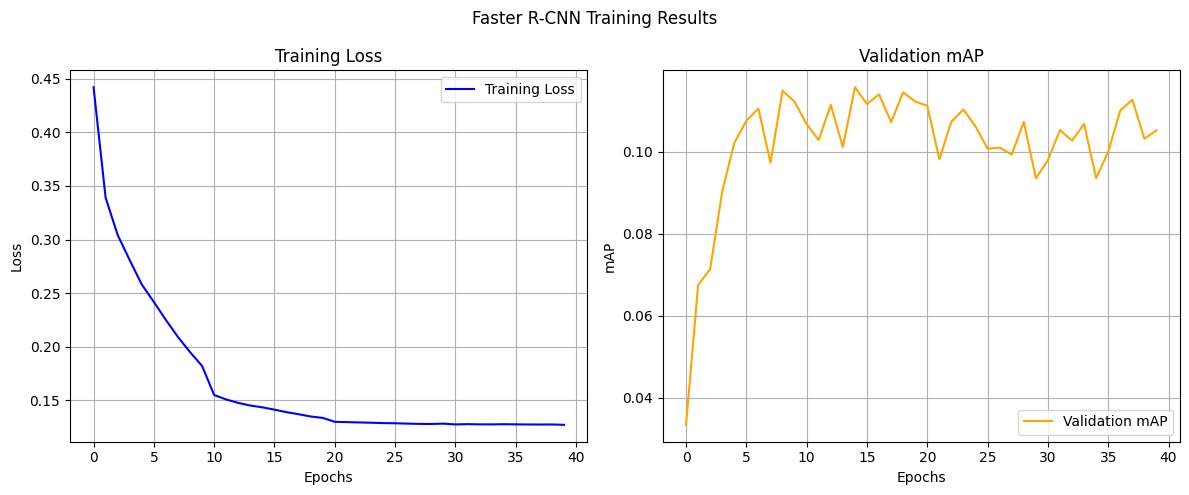

In [11]:
### Plotting results:

frcnn_results_path = 'frcnn_40.pkl'

with open(frcnn_results_path, 'rb') as file:
    data = pickle.load(file)

training_loss = data['loss']
val_mAP = data['mAP']

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Training loss:
axs[0].plot(training_loss, label='Training Loss', color='blue')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Validation mAP:
axs[1].plot(val_mAP, label='Validation mAP', color='orange')
axs[1].set_title('Validation mAP')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('mAP')
axs[1].legend()
axs[1].grid(True)

plt.suptitle("Faster R-CNN Training Results")

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig("FRCNN_results.png", dpi=600)
plt.show()


